In [2]:
!pip install black

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [black]32m4/5 [black]


Prix de l’option: 3.338110063423771
Black-Scholes Price: 3.3402


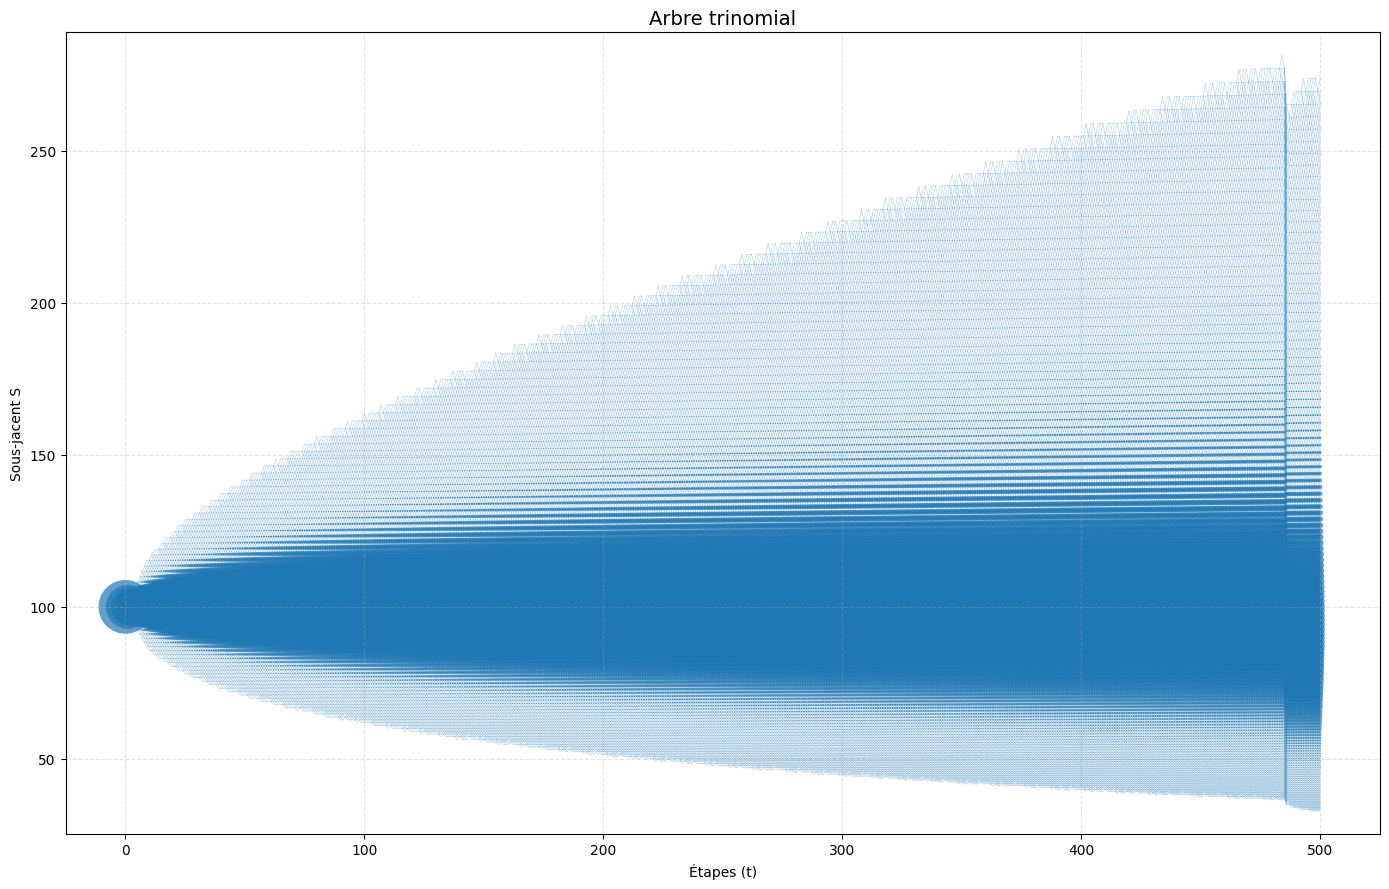

In [3]:
from pricing import BlackScholesPricer, TrinomialTree, Market, Option
from pricing import convergence
import datetime as dt
import              sys
import logging

sys.setrecursionlimit(100)
market = Market(S0=100, r=0.03, sigma=0.2, dividend=6, dividend_date=dt.datetime(2026, 10, 20))
option = Option(K=110, option_type="call", maturity=dt.datetime(2026, 10, 30), option_class="european")
tree = TrinomialTree(market, option, N=500, pruning=True, epsilon=1e-7)

# tree._compute_parameters(100)
# tree.root = tree._build_tree()

price = tree.price(option)
print("Prix de l’option:", price)

bs_price = BlackScholesPricer().price(S=market.S0, K=option.K, T=tree.delta_t*tree.N, r=market.r, sigma=market.sigma, option_type='call', dividend=market.dividend, dividend_date = market.dividend_date) # q=0 car pas de dividendes
print("Black-Scholes Price: {:.4f}".format(bs_price))

tree.plot_tree(tree.N)
# convergence.bs_convergence_by_strike(market, option, [80, 90, 100, 110, 120, 130, 140, 150, 160], N=tree.N)

# convergence.bs_convergence_by_step(market, option, bs_price, max_n = 100, step = 20)

In [ ]:
# soutenance sur teams de 30 min
# 2 quizz jusqu'à 17h le 29/10 : un qualitatif -> questions et un quantitatif où on va 
# devoir utiliser notre code pour répondre (possible de faire un ajout de code aussi)
# exemple qualitatif : quelle est le plus gros reproche de l'abre trinomial

pricer backward :
- calcul avec une boucle for sans limite de récursion
- on commence les calculs par le noeud de la fin
- allez à la fin avec les truncs nodes
- on calcul la valeur intrinsèque dans la dernière colonne
- on va ajouter le fait de revenir un cran en arrière sur le noeud tronc
- on peut avoir une classe TruncNode qui dérive de Node
- il faut aussi que n'importe quelle noeud de la colonne connaisse son TruncNode
- ensuite on remonte noeud par noeud et utilise la même fonction price que le récursif (la même forme)

problème des probas pas dans 0, 1:
il faut que le noeud mid soit le plus proche de l'espérance --> il faut changer de noeud mid quand ça dépasse 1 ou en dessous de 0
il va falloir attribuer next_mid en cherchant autour
lui sa construction il l'a fait en montant petit à petit dans les deux colonnes t et t+1 en même temps
tant que le next_mid est entre le next_mid actuel et la moyenne entre next_mid et next_up alors on garde ce next_mid sinon on attribue next_mid comme étant next_up, attribuer next_mid au noeud le plus proche de l'espérance --> calculer la moyenne entre le deux noeuds possible
le problème vient des noeuds du bas avec des valeur négative quand on soustrait le div--> résolu par le pruning qui enlève beaucoup de noeuds du bas

il faudrait que la colonne t sache que la colonne t+1 reçoit le dividende

REGARDER LES GRAPHS LOG LOG AVANT DE FAIRE LE PRUNING

Pruning : 
- soit proba d'arriver au noeud
- soit nombre d'écart type de S avec le trunc node (4 écarts types)
- chaque noeud à sa proba
- chaque noeud vient peut être de 3 noeud, à chaque fois qu'on fait une liaison vers ce noeud on rajoute à la proba cumulé du noeud vers lequel on va la contribution du noeud parent : next_down.proba_cumulée = next_down.proba_cumulée + current_node.proba ---> méthode dans Node
quand on monte dans l'arbre et que c'est trop petit, on fait juste un next_mid avec une proba de 1 ---> monomial ---> tant que c'est trop petit ---> monomial
le noeud qui a une proba faible crée un noeud monomial ! il existe mais ne crée pas plusieurs noeud c'est tout
- autre méthode = écart type

delta: prix_option en S0+epsilon (dans le temps) + prix_option en S0-epsilon/ 2*epsilon
c'est au QCM ça.
Les risk managers font des delta en pourcentage de la valeur du produit pour avoir des calls en % pour pouvoir comparer des produits similaires. Le epsilon est par exemple 1% de la valeur du produit. epsilon = 0.4 pour un produit à 40 et 4 pour un produit à 400 (décalage d'1%)
Il faudra utiliser la première méthode pour le QCM.

Gamma: dérivé du delta donc --> delta+ - delta- si unité de 1 de décalage
Avec un epsilon : (delta+(de epsilon) - delta-)/epsilon
à partir du prix = (Prixoption(S0 + epsilon) + Prixoption(S0-epsilon) - 2*Prixoption(S0)) / epsilon^2

Vega : (dérivé du prix par sigma) * 1%
 = (PrixS0 + 1% - PrixS0 - 1%)/2 car c'est de la vol

vega = dérivé seconde par rapport à la vol

vanna = dérivé croisée = dérivé du vega par rapport au spot = dérivée du delta par rapport à la vol


dérivée dans le code:
le callable est une fonction qui doit prendre un float en argument (valeur par rapport à laquelle on dérive)
shift = amplituyde de la variation

In [ ]:
# from typing import *

# class OneDimDerivative:

#     def __init__(self, function: Callable[[object, float], float],
#                  other_parameters: object, shift: float = 1):
#         self.f: Callable[[object, float], float] = function
#         self.param: object = other_parameters
#         self.shift: float = shift

#     def first(self, x: float) -> float:
#         return (self.f(self.param, x + self.shift)
#                 - self.f(self.param, x - self.shift)) / (2 * self.shift)
    

# def OptionDeltaBackward(market_range: numpy.array, pricing_range: numpy.array, option_range: numpy.array) -> float:
#     return OneDimDerivative(cast((object, float), _PriceTreeBackward_OneDimPrice),
# OptionPricingParam(market_range, pricer_range, option_range),
# market_range[0] * OptionPricingParam.UND_SHIFT).first(market_range[0])

In [ ]:
def create_mid_w_div(self, tree, i: int, dividend: bool = False):
    """
    Variante 'ex-div' de create_mid :
    - crée le trunc (premier mid de la colonne) à forward - D
    - lors de la montée/descente, rattache self.next_mid au nœud t+1 le plus
      proche de forward - D pour CE nœud, même si c’est un cran au-dessus/en-dessous
      de down.next_up / up.next_down (décalage ±alpha).
    - recalcule les paramètres (p_up, p_mid, p_down) localement si on crée un
      nouveau mid à l’étape ex-div.
    """
    # pré-calculs
    proba_mid = self.proba * tree.p_mid
    forward = self.S * np.exp(tree.market.r * tree.delta_t)
    s_target = forward - tree.market.dividend if dividend else forward

    # --- Cas sans dividende : on retombe sur la version standard
    if not dividend:
        # garde le comportement d'origine
        return self.create_mid(tree, i, dividend=False)

    # --- Ex-dividende : tenter de RÉUTILISER un nœud existant côté colonne t+1
    # Candidats naturels issus des frères déjà construits :
    candidates = []

    # côté "bas" -> son next_up et ses voisins verticaux (±alpha)
    if self.down is not None and self.down.next_up is not None:
        base = self.down.next_up
        candidates += [base]
        if base.up is not None:
            candidates.append(base.up)
        if base.down is not None:
            candidates.append(base.down)

    # côté "haut" -> son next_down et ses voisins verticaux (±alpha)
    if self.up is not None and self.up.next_down is not None:
        base = self.up.next_down
        candidates += [base]
        if base.up is not None:
            candidates.append(base.up)
        if base.down is not None:
            candidates.append(base.down)

    # dédup & purge None
    uniq = []
    seen = set()
    for c in candidates:
        if c is None:
            continue
        cid = id(c)
        if cid not in seen:
            seen.add(cid)
            uniq.append(c)

    if uniq:
        # choisir le nœud de la colonne t+1 le plus proche de forward - D pour CE nœud
        chosen = min(uniq, key=lambda n: abs(n.S - s_target))
        self.next_mid = chosen
        chosen.proba += proba_mid

        # rattachement 'trunc' (chaîne horizontale)
        if self.trunc is None:
            self.trunc = self
        # si le candidat a déjà son propre trunc, on propage
        self.next_mid.trunc = getattr(chosen, "trunc", chosen)
        self.next_mid.prev_trunc = self.trunc

        # Cas particulier évoqué : décalage +α depuis down.next_up -> choisir down comme next_down
        if (self.down is not None and self.down.next_up is not None
                and self.down.next_up.up is self.next_mid):
            # relier le down pour éviter une création/doublon plus tard
            self.next_down = self.down.next_up
            # liens verticaux cohérents
            self.next_mid.down = self.next_down
            self.next_down.up = self.next_mid

        # Symétrique : décalage -α depuis up.next_down -> choisir up comme next_up
        if (self.up is not None and self.up.next_down is not None
                and self.up.next_down.down is self.next_mid):
            self.next_up = self.up.next_down
            self.next_mid.up = self.next_up
            self.next_up.down = self.next_mid

        # NB : on laisse create_up/create_down compléter/créer le frère manquant
        return

    # --- Sinon : aucun candidat pertinent existant -> CRÉER le mid à s_target
    # recalibration locale des probas au pas ex-div autour de s_target
    tree._compute_parameters(self.S, s_target, dividend=True)

    self.next_mid = Node(S=s_target, proba=proba_mid)
    self.next_mid.tree = self

    # rattachement central (chaîne des trunc)
    if self.trunc is None:
        self.trunc = self
    self.next_mid.trunc = self.next_mid
    self.next_mid.prev_trunc = self.trunc


In [ ]:
def create_up(self, tree: object, pruning: bool, is_bord: bool, dividend: bool):
    proba_up = self.proba * tree.p_up

    # >>> ne pas recréer si déjà câblé (ex: cas -α symétrique)
    if self.next_up is not None:
        self.next_up.proba += proba_up
        return
    ...


In [ ]:
def create_down(self, tree: object, pruning: bool, is_bord: bool, dividend: bool):
    proba_down = self.proba * tree.p_down

    # >>> ne pas recréer si déjà câblé (ex: cas +α évoqué)
    if self.next_down is not None:
        self.next_down.proba += proba_down
        return
    ...
